# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

## Interpolate the N2 vector onto a uniform pressure grid

In [11]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [12]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [13]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [14]:
import VERT_FSFB3

In [15]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [16]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [17]:
SSH = G/g

In [18]:
Z_mid_uniform  = gsw.z_from_p(np.append(0, Pmid), lat = laty)

In [19]:
MODE = G.shape[-1]

In [20]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

### Beta plane paramters

In [21]:
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

### SSH - 15 waves, 5 baroclinic modes, 3 wavenumbers, 5 modes, 15 frequencies, 30 amplitudes

#### The dispersion relation relates frequency to wavenumber for each mode:

In [22]:
MModes = 5 # 
wavelength = np.array([2e5, 1e5, .5e5]) # 200km, 100km, 50km
wavespeed = c2[:MModes] # Phase speed
k_n = 2 * np.pi / wavelength # wavenumber
Rm = wavespeed[:MModes] / f0 # Rossby deformation radius
wavelength_l = 0.4 * wavelength
l_n = 2 * np.pi / wavelength_l # Y direction wavenumber
freq_n = np.zeros([len(wavelength), MModes])
for nn in range(len(k_n)):
    for mm in range(MModes):
        freq_n[nn, mm] = (Beta * k_n[nn]) / (k_n[nn] ** 2 + l_n[nn] ** 2 + Rm[mm] ** (-2))
Amp = np.random.rand(2, MModes, len(wavelength))
M = Amp.size

#### SWOT swath: two 50km swaths with 20 km gap in middle

In [23]:
a, b, c, d = 0, 1, 50, 1
x0 = np.arange(0, 50, 1)
y0 = np.arange(0, 50, 1)
xswath_index0 = a + b * x0
yswath_index0 = c + d * y0
swath_ysize = 12
yswath_index = np.ma.masked_all([12, len(yswath_index0)])
xswath_index = np.ma.masked_all([12, len(xswath_index0)])
for yy in range(1, swath_ysize):
    if(yy!= 6&7):
        yswath_index[yy] = yswath_index0 + yy
        xswath_index[yy] = xswath_index0

In [24]:
yswath_index = np.ma.masked_greater_equal(yswath_index, 100)
y_mask = np.ma.getmask(yswath_index)
xswath_index = np.ma.masked_where(((yswath_index ==100)&(yswath_index>100)), xswath_index)

#### Retrieve valid data and random sample in time 

In [25]:
yvalid_index = yswath_index.compressed().astype(int) # retrieve the valid data 
xvalid_index = xswath_index.compressed().astype(int) # retrieve the valid data 
tindex = np.random.randint(low = 0, high= 99, size= xvalid_index.size)  # Random sampling in time

In [26]:
N = yvalid_index.size
N == xvalid_index.size

True

In [27]:
X_loc = np.arange(0, 1e6, 1e4)[xvalid_index] # domain size 1000 km with 10km resolution
Y_loc = np.arange(0, 1e6, 1e4)[yvalid_index]
T_time = np.arange(0, 1e10, 1e8)[tindex] # seconds, Time step : ~11days

### H Matrix and SSH

### Construct model in vector space

In [28]:
%%time
N_data = N
H_cos = np.zeros([N_data, MModes, len(wavelength)]) # Number of waves * Number of data
H_sin = np.zeros([N_data, MModes, len(wavelength)])
SSH_MN = np.ma.masked_all([N_data, MModes, len(wavelength)])
for tt in range(N_data):
    for mm in range(Amp.shape[1]):
        for nn in range(len(k_n)):
            H_cos[tt, mm, nn] = Psi[0, mm] * np.cos(k_n[nn] * X_loc[tt] + l_n[nn] * Y_loc[tt] + freq_n[nn, mm] * T_time[tt]) 
            H_sin[tt, mm, nn] = Psi[0, mm] * np.sin(k_n[nn] * X_loc[tt] + l_n[nn] * Y_loc[tt] + freq_n[nn, mm] * T_time[tt])

CPU times: user 28.2 ms, sys: 1.02 ms, total: 29.2 ms
Wall time: 28.4 ms


In [29]:
for mm in range(MModes):
    for nn in range(len(k_n)):
        SSH_MN[ :, mm, nn] = Amp[0, mm, nn] * H_cos[ :, mm, nn] + Amp[1, mm, nn] * H_sin[:, mm, nn]

SSH = SSH_MN.sum(axis = (-1, -2))

IIndex = np.zeros(N_data) # N: Number of y data
Y_v = np.zeros(N_data) 
H_v = np.zeros([N_data, M]) # M: number of model

for iii in range(N_data):
    Y_v[iii] = SSH[iii]
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[iii, mm, nn]
            H_v[iii, JIndex + 1] = H_sin[iii, mm, nn]

### Exact-solution - Solve 30 unknow amplitudes with 30 data points.

#### Weighted least square solution

#### R and P Matrix

In [30]:
R_ = np.eye(N, N)

In [31]:
P_ = np.eye(M, M)

In [32]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [33]:
A = np.matmul(H_v.T, LA.inv(R_))

In [34]:
HRH = np.matmul(A, H_v)

In [35]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

#### if the Eigenvalues of HRH are -->0, the problem is poorly conditioned. Otherwise, the problem is well conditioned.

In [36]:
eig, vec = LA.eig(HRH)
eig.real

array([24422.17706799, 23965.81133328, 19546.91354919, 18465.73690523,
       16401.50917127, 15403.75522759,  6316.04090219,  5901.32518303,
        5771.60097524,  4912.09915888,  4704.83102558,  4384.55093105,
        4139.19707708,  4013.67722646,  3853.31025596,  3712.36548075,
          82.29095922,   106.32659706,  1794.98689815,  1770.21995666,
        1349.85978747,  1615.51980003,  1559.07462935,  1477.35207424,
         824.98110015,   573.32824446,   599.51480312,   711.13198443,
         678.2893685 ,   658.72397603])

#### Soution with noise

In [37]:
X_ = np.matmul(D, Y_v)

In [38]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

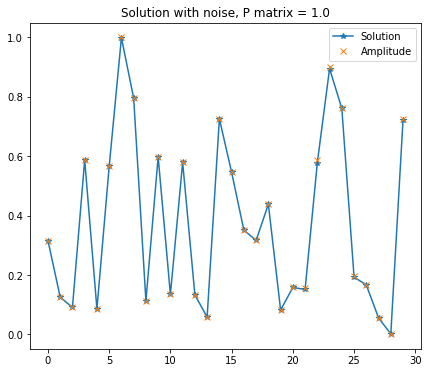

In [39]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'*-', label = 'Solution')
plt.plot(Amp.reshape([30], order = 'F'),'x',label = 'Amplitude')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'.png')

In [40]:
diff = SOL_WN - Amp.reshape([M], order = 'F')

In [41]:
rms = np.sqrt(np.mean(diff**2))
rms

0.002186108478200055

#### Create simulated roll error

In [42]:
alpha2 = -1e-5
roll_err = np.ma.masked_all(yswath_index.shape)
xc = np.ma.masked_all(yswath_index.shape)
ac, al = roll_err.shape
for xx in range(ac):
    xc[xx, :] = (xx - (ac-1)/2) 
    roll_err[xx, :] = alpha2 * xc[xx, :] * 1e4 #10km resolution

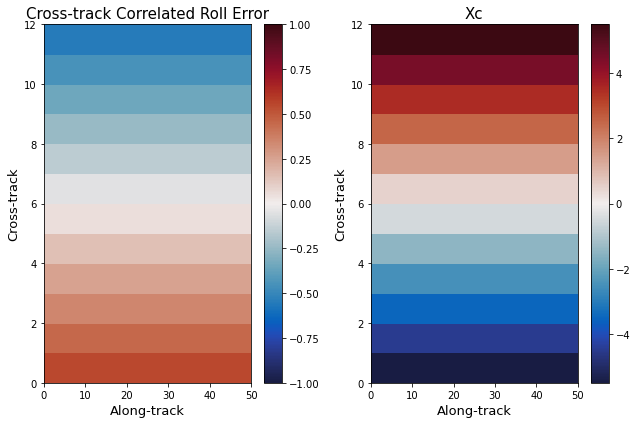

In [43]:
plt.figure(figsize = (9, 6))
plt.subplot(121)
plt.pcolor(roll_err, cmap = cmo.cm.balance, vmin = -1, vmax = 1)
plt.colorbar()
plt.xlabel('Along-track', fontsize = 13)
plt.ylabel('Cross-track', fontsize = 13)
plt.title('Cross-track Correlated Roll Error', fontsize = 15)

plt.subplot(122)
plt.pcolor(xc, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Along-track', fontsize = 13)
plt.ylabel('Cross-track', fontsize = 13)
plt.title('Xc', fontsize = 15)
plt.tight_layout()
plt.savefig('Cross_track_Correlated_Roll_Error.png', dpi = 100)

In [44]:
roll_err_masked = np.ma.MaskedArray(roll_err, y_mask)
xc_masked = np.ma.MaskedArray(xc, y_mask)

In [45]:
roll_err_valid = roll_err_masked.compressed().astype(int) # retrieve the valid data 
xc_valid = xc_masked.compressed().astype(int) # retrieve the valid data 

#### Add simple roll error to SSH

In [46]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M+1]) # M: number of model
nx, ny = N, N
for iii in range(N):
    Y_v[iii] = SSH[iii] + roll_err_valid[iii]
    H_v[iii, -1] = xc_valid[iii] # distance from nadir Xc 
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[iii, mm, nn]
            H_v[iii, JIndex + 1] = H_sin[iii, mm, nn]

#### Weighted least square solution

#### R and P Matrix

In [47]:
R_ = np.eye(N, N)

In [48]:
P_ = np.eye(M+1, M+1)

In [49]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M + 1):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [50]:
A = np.matmul(H_v.T, LA.inv(R_))

In [51]:
HRH = np.matmul(A, H_v)

In [52]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

In [53]:
HRH.shape, LA.inv(P_).shape

((31, 31), (31, 31))

In [54]:
eig, vec = LA.eig(HRH)
eig.real

array([3.65365918e+05, 2.42954499e+04, 2.35772195e+04, 1.94566707e+04,
       1.84506714e+04, 1.63667207e+04, 1.53154885e+04, 6.31427678e+03,
       5.89832649e+03, 5.77088941e+03, 4.89779198e+03, 4.69890216e+03,
       4.37790970e+03, 4.08288879e+03, 4.00980481e+03, 3.85071543e+03,
       3.70636441e+03, 8.21487387e+01, 1.06306608e+02, 1.79481008e+03,
       1.76953345e+03, 1.61273540e+03, 1.55905374e+03, 1.34796841e+03,
       1.46881741e+03, 8.22061538e+02, 5.72016557e+02, 5.98507334e+02,
       7.10798174e+02, 6.77802829e+02, 6.57933120e+02])

#### Soution with noise

In [55]:
X_ = np.matmul(D, Y_v)

In [56]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

In [57]:
AMP_alpha2 = np.append(Amp.reshape([30], order = 'F'), alpha2)

In [58]:
AMP_alpha2[-1], SOL_WN[-1], SOL_WN[-1] - AMP_alpha2[-1]

(-1e-05, -7.400084631421083e-06, 2.5999153685789175e-06)

In [59]:
AMP_alpha2[:], SOL_WN[:]

(array([ 3.15862273e-01,  1.25153651e-01,  9.04442547e-02,  5.87448000e-01,
         8.54983672e-02,  5.65489119e-01,  9.99878601e-01,  7.95831303e-01,
         1.12548603e-01,  5.98338275e-01,  1.34504442e-01,  5.79009536e-01,
         1.33056544e-01,  5.80495335e-02,  7.26361942e-01,  5.45701970e-01,
         3.51377963e-01,  3.16428261e-01,  4.39213339e-01,  8.19892872e-02,
         1.59520163e-01,  1.56041424e-01,  5.85743551e-01,  9.02020168e-01,
         7.60709581e-01,  1.95142468e-01,  1.65888669e-01,  5.46706846e-02,
         1.19640545e-03,  7.24229520e-01, -1.00000000e-05]),
 array([ 3.15809031e-01,  1.25085374e-01,  9.06081720e-02,  5.87345073e-01,
         8.53161063e-02,  5.65332026e-01,  9.99161727e-01,  7.95373758e-01,
         1.12598164e-01,  5.97337983e-01,  1.34523982e-01,  5.78981717e-01,
         1.32859127e-01,  5.80801994e-02,  7.25925264e-01,  5.45593501e-01,
         3.50866483e-01,  3.16129215e-01,  4.38470019e-01,  8.19290687e-02,
         1.57805348e-01,  1

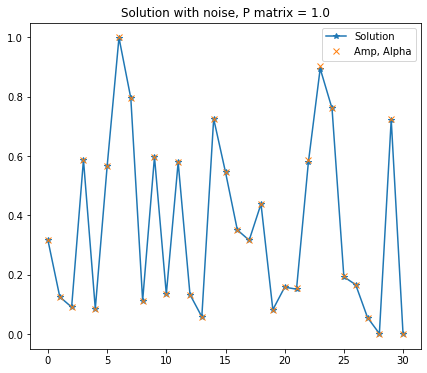

In [60]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'*-', label = 'Solution')
plt.plot(AMP_alpha2,'x',label = 'Amp, Alpha')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'_alpha2Xc.png')

In [61]:
diff = SOL_WN - AMP_alpha2

In [62]:
rms = np.sqrt(np.mean(diff**2))
rms

0.0021540119480763847